In [1]:
using BenchmarkTools, LinearAlgebra, BandedMatrices, Polynomials, PyPlot, LaTeXStrings, CSV, DataFrames, Dates
include("backSub.jl")
include("invBiU.jl")

BLAS.get_num_threads()


# BLAS.set_num_threads(8)
# BLAS.get_num_threads()


8

In [ ]:

function getU(n, bᵤ, Utype="mat", elmtype="float")
    if Utype == "banded"
        if elmtype == "bigfloat"
            U = big.(BandedMatrix(rand(n, n), (0, bᵤ))) + 100*I
        else
            U = BandedMatrix(rand(n, n), (0, bᵤ)) + 100*I
        end
        println(typeof(U))
        return U
    end

    if elmtype == "bigfloat"
        U = big.(rand(n, n)) + 100*I
    else
        U = rand(n, n) + 100*I
    end

    if Utype == "bidiag" && bᵤ == 1
        U = Bidiagonal(U, :U)
    else
        U = triu(U) - triu(U, bᵤ+1) + 100*I
    end
    println(typeof(U))
    U;
end


function timer4Uxb(func, dims, bᵤ, Utype, elmtype, rept, nthreads)
    BLAS.set_num_threads(nthreads)
    times4func = zeros(length(dims))
    for (i, n) in enumerate(dims)
        U = getU(n, bᵤ, Utype, elmtype)
        atime4func = 0.0
        for _ in 1:rept
            atime4func += @elapsed func(U)
        end
        times4func[i] = atime4func / rept
    end
    times4func;
end

function error4Uxb(func, dims, bᵤ, Utype, elmtype, rept, nthreads)
    BLAS.set_num_threads(nthreads)
    A = getU(3, 1, Utype, elmtype)
    T = eltype(A)
    abserrors4func = zeros(T, length(dims))
    relerrors4func = zeros(T, length(dims))
    for (i, n) in enumerate(dims)
        U = getU(n, bᵤ, Utype, elmtype)
        x = rand(T, n)
        b = U * x
        abserr = zero(T)
        relerr = zero(T)
        for _ in 1:rept
            Uinv = func(U)
            x̂ = Uinv * b
            abserr += norm(x - x̂)
            relerr += abserr / norm(x)
        end
        abserrors4func[i] = convert(T, abserr / rept)
        relerrors4func[i] = convert(T, relerr / rept)
        println(abserrors4func[i])
        println(relerrors4func[i])
    end
    abserrors4func;
    relerrors4func;
end



function data4plot(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)
    timeusage = zeros(length(funcs), length(dims))
    for (i, func) in enumerate(funcs)
        timeusage[i, :] = timer4Uxb(func, dims, bᵤ, Utype, elmtype, rept, nthreads)
    end
    timeusage;
    # erroranalysis = zeros(length(funcs), length(dims))
    # for (i, func) in enumerate(funcs)
    #     erroranalysis[i, :] = error4Uxb(func, dims, bᵤ, Utype, elmtype, rept, nthreads)
    # end
    # erroranalysis;
end


# timedata = data4plot(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)

# plot(timedata)
function plot4data(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)
    timedata = data4plot(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)
    # println(timedata)
    colorlist = ["red", "blue", "green"]
    linestylelist = ["-.", "--"]
    figure()
    for (i, func) in enumerate(funcs)
        loglog(dims, timedata[i, :], color=colorlist[i], linewidth=1.0, linestyle=linestylelist[i], base=2, label=string(func))
        # plot(dims, timedata[i, :], color=colorlist[i], linewidth=1.0, linestyle=linestylelist[i], label=string(func))
    end
    xlabel(L"size of $U$, $N$")
    ylabel("Wall time")
    # ylabel("Error")
    grid()
    legend()
    title(L"Time usage for computing $U^{-1}$")
    # title(L"Error for computing $Ux=b$")
    # savefig("errors_inv_InvBiU", dpi=150)
    # sss = "11111"
    # xxx = "2222"
    # savefig("./figure/$sss.png", dpi=150)
    # savefig("./figure/$xxx.eps", format="eps")
    timedata
end


function invBanded(U)
    qr(U) \ I
end

funcs = [invBidiagU, inv]
funcs = [inv]
# funcs = [invBidiagU, invBanded]

dims = [2^i for i in 6:13]
bᵤ = 1
Utype = "mat"
Utype = "bidiag"
# Utype = "banded"
# elmtype = "bigfloat"
elmtype = "float"
rept = 8
nthreads = 1

# "bidiag" "big" "banded"
# plot4data(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)
# elmtype = "bigfloat"
timetaken = plot4data(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)

In [ ]:
figure(1)
nlist = dims
tk1 = timetaken[end, :]
loglog(nlist, tk1, color="red", linewidth=2.0, linestyle="-.", base = 2)
# plot(nlist, tk1, color="red", linewidth=2.0, linestyle="-.")


fst = 1
lst = length(nlist)



# ploy1 = fit(nlist[fst:lst].*log2.(nlist[fst:lst]), tk1[fst:lst], 1)
# b1, a1 = ploy1.coeffs[1], ploy1.coeffs[2]
# println((a1, b1))

ploy2 = fit(nlist[fst:lst], tk1[fst:lst], 2)
println(ploy2)
c, b, a = ploy2.coeffs[1], ploy2.coeffs[2], ploy2.coeffs[3]

println((c, b, a ))

loglog(nlist, a.*nlist.^2 .+ b.*nlist .+ c, color="blue", linewidth=2.0, linestyle="dotted", base = 2)
# plot(nlist, a.*nlist.^2 .+ b.*nlist .+ c, color="blue", linewidth=2.0, linestyle="dotted")

xlabel(L"$N$ $\alpha$")
ylabel("Wall time")
grid()
legend()
title("Total time for heap pop and push during gSearch under different N")




set thread
set thread
set thread
set thread
set thread
set thread
set thread
set thread
set thread


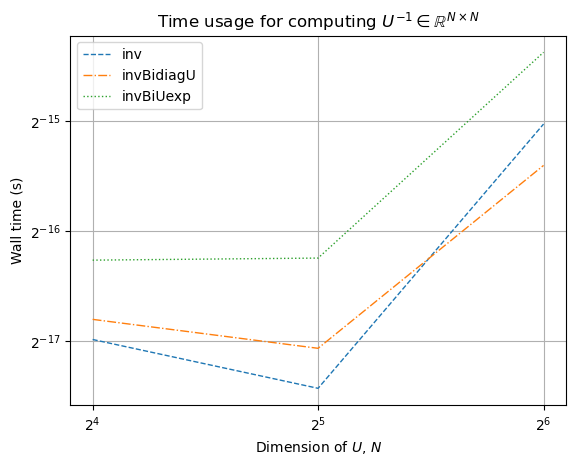

3×3 Matrix{Float64}:
 7.708e-6   8.75e-6    1.2708e-5
 5.666e-6   7.291e-6   1.2875e-5
 2.9959e-5  2.3084e-5  4.7084e-5

In [33]:
using BenchmarkTools, LinearAlgebra, BandedMatrices, PyPlot, LaTeXStrings, CSV, DataFrames, Dates

include("genTestMat.jl")
include("backsub.jl")
include("invBiU.jl")
include("invBiUExp.jl")


function timeAvg4func(func, testMat, rept, nThreads)
    BLAS.set_num_threads(nThreads)
    time = 0.0
    for _ in 1:rept
        time += @elapsed func(testMat)
    end
    time / rept;
end


function timesData4funcs()
    dims = [2^i for i = 4:6]
    # dims = [Int64(floor(2^(i/2))) for i in 4:22]
    # dims = [100*2^i for i in 0:5] # for bidiag only
    bw = 1
    typeM = Matrix
    typeM = Bidiagonal
    typeElmt = Float64
    isUpper = true
    rept = 10
    rept = 1
    nThreads = 1
    funcs = [inv, invBidiagU, invBiUexp]
    saveData = true
    saveFig = true
    saveData = false
    saveFig = false


    timesData = zeros(length(dims), length(funcs))

    BLAS.set_num_threads(nThreads)
    for (j, func) in enumerate(funcs)
        for (i, n) in enumerate(dims)
            testMat = generateTestTriangular(n, bw, typeM, typeElmt, isUpper)
            timesData[i, j] = timeAvg4func(func, testMat, rept, nThreads)
        end
    end
    BLAS.set_num_threads(8)

    if saveData
        df_data = DataFrame(timesData, :auto)
        rename!(df_data, string.(funcs))
        df_dims = DataFrame(size = dims)
        df = hcat(df_dims, df_data)
        time = string(now())
        CSV.write("./data/efficiency/$time$typeM$typeElmt.csv", df)
        # CSV.write("./data/accuracy/$time$typeM$Float64.csv", df)
    end

    linestylelist = ["--", "-.", ":", "-", ]

    figure()
    for (j, func) in enumerate(funcs)
        # loglog(dims, timesData[:, j], color=colorlist[j], linewidth=1.0, linestyle=linestylelist[j], base=2, label=string(func))
        loglog(dims, timesData[:, j], linewidth=1.0, linestyle=linestylelist[j], base=2, label=string(func))
    end
    xlabel(L"Dimension of $U$, $N$"), ylabel("Wall time (s)"), grid(), legend()
    title(L"Time usage for computing $U^{-1} \in \mathbb{R}^{N \times N}$")
    show()
    if saveFig
        savefig("./figure/efficiency/$time$typeM$typeElmt.png", dpi=150)
        savefig("./figure/efficiency/$time$typeM$typeElmt.eps", format="eps")
    end
    timesData;
end



timesData4funcs()


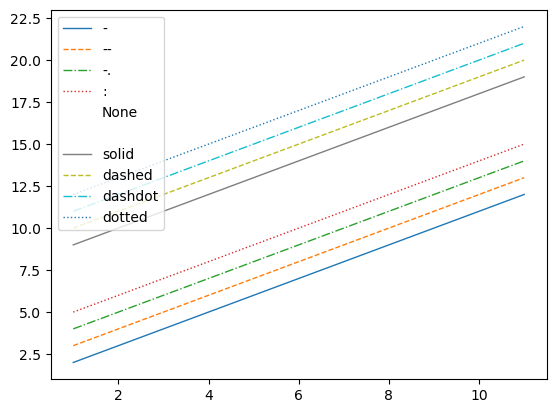

PyObject <matplotlib.legend.Legend object at 0x2b39d8f40>

In [34]:
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'"


ls = ["-", "--", "-.", ":", "None", " ", "", "solid", "dashed", "dashdot", "dotted"]
n = length(ls)
figure()
x = [i for i = 1:n]
for i = 1:n
    plot(x, i.+x, linewidth=1.0, linestyle=ls[i], label=ls[i])
#     # plot(dims, timedata[i, :], color=colorlist[i], linewidth=1.0, linestyle=linestylelist[i], label=string(func))
end
legend()


In [20]:
function func11(A)
    inv(A)
end
function func22(A)
    inv(A)
end

funcs = [func11, func22]

rept = 2
time = 0.0
for (i, func) in enumerate(funcs)
    for _ in 1:rept
        time += @belapsed func(rand(3,3))
    end
end
time / rept

LoadError: UndefVarError: func not defined

In [32]:
rept = 100
time = 0.0
A = rand(3,3)
    for _ in 1:rept
        time += @elapsed inv(A)
    end
display(time / rept)
@belapsed inv(A)

9.078500000000002e-7

3.2142857142857145e-7

In [ ]:
# using Dates, CSV, DataFrames
# string(now())

# dims = [2^i for i = 4:9]
# # println(typeof(dims))
# data = timesData4funcs()

# df_data = DataFrame(data, :auto)
# rename!(df_data, string.([inv, invBidiagU]))
# df_dims = DataFrame(size = dims)
# df = hcat(df_dims, df_data)

# # # # [inv, invBidiagU]
# # # df
# time = string(now())

# CSV.write("./data/$time.csv", df)



In [31]:
[Int64(floor(2^(i/2))) for i in 4:20]
[100*2^i for i in 0:10]

11-element Vector{Int64}:
    100
    200
    400
    800
   1600
   3200
   6400
  12800
  25600
  51200
 102400

In [ ]:
a = [inv, invBidiagU]
append!(string.(a), string.(a))

In [ ]:
typeof(@belapsed inv(rand(5,5)+5I))

In [ ]:
#  nonHermitian posi def

function genNonHPosiDef(m)
    function genGLap(m)
        A = ones(m, m)
        for _ in 1:Int64(floor(m^2/2))
            i, j = rand(1:m), rand(1:m)
            A[i, j] = 0
        end
        A1 = triu(A, 1)
        A2 = A1'
        A3 = A1 + A2
        d = sum(A3, dims = 1)
        # display(A3)
        # display(d)
        D = Diagonal(vec(d))
        # display(D)
        GL = D - A3
        GL;
    end
    B = genGLap(m) + I
    C = genGLap(m) + I
    A = B + 1.0im.*C
    A
end

AAA = genNonHPosiDef(6)
display(AAA)
isposdef(AAA) # false ?


In [ ]:
floatmin() * floatmin()